# Week 8 - Instrumental Variables

This notebook uses an instrumental variable approach to estimate the returns from schooling, namely the effect of higher education on earnings. The reference paper for this notebook is [Angrist and Krueger (1991)](https://www.jstor.org/stable/2937954?seq=2#metadata_info_tab_contents).

To investigate this, we instrument education using the quarter of birth of individuals. This instrument relies on compulsory school attendance law. The idea behind it is that people born in the first 3 quarters can drop out of school one year earlier than those born in the last quarter.

In [1]:
# Common imports
import numpy as np
import os
import pandas as pd

# To plot pretty figures
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl
import matplotlib.pyplot as plt
#%matplotlib notebook
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import seaborn as sns
sns.set_theme()
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings = lambda *a, **kw: None

df = pd.read_stata('data/ak91.dta')
pd.read_stata('data/ak91.dta', iterator=True).variable_labels()

{'AGE': '',
 'AGEQ': '',
 'EDUC': '',
 'ENOCENT': '',
 'ESOCENT': '',
 'LWKLYWGE': '',
 'MARRIED': '',
 'MIDATL': '',
 'MT': '',
 'NEWENG': '',
 'CENSUS': '',
 'QOB': '',
 'RACE': '',
 'SMSA': '',
 'SOATL': '',
 'WNOCENT': '',
 'WSOCENT': '',
 'YOB': '',
 'COHORT': '',
 'AGEQSQ': '',
 'YR20': '',
 'YR21': '',
 'YR22': '',
 'YR23': '',
 'YR24': '',
 'YR25': '',
 'YR26': '',
 'YR27': '',
 'YR28': '',
 'YR29': '',
 'QTR1': '',
 'QTR2': '',
 'QTR3': '',
 'QTR4': '',
 'random': ''}

In [2]:
df.head()

,AGE,AGEQ,EDUC,ENOCENT,ESOCENT,LWKLYWGE,MARRIED,MIDATL,MT,NEWENG,...,YR25,YR26,YR27,YR28,YR29,QTR1,QTR2,QTR3,QTR4,random
0,46,46.25,18,0,0,5.908553,1,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,7.227906e-08
1,45,45.25,11,0,0,5.464953,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.183647e-06
2,43,43.00,11,1,0,5.559889,1,0,0,0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,2.024221e-06
3,42,42.00,16,0,0,5.790019,1,0,0,0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,2.418815e-06
4,48,48.00,11,0,0,5.829240,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3.485916e-06


In [3]:
df.COHORT.head()

0    30.389999
1    20.290001
2    20.290001
3    30.389999
4    30.389999
Name: COHORT, dtype: float32

For this analysis we will focus only on the 1940-1949 cohort. 

In [4]:
df['yob_q'] = df['YOB'] + (df['QOB']*0.25 - 0.25)


df40 = df.loc[df['COHORT']>39]
df40 = df40.loc[df['COHORT']<50]

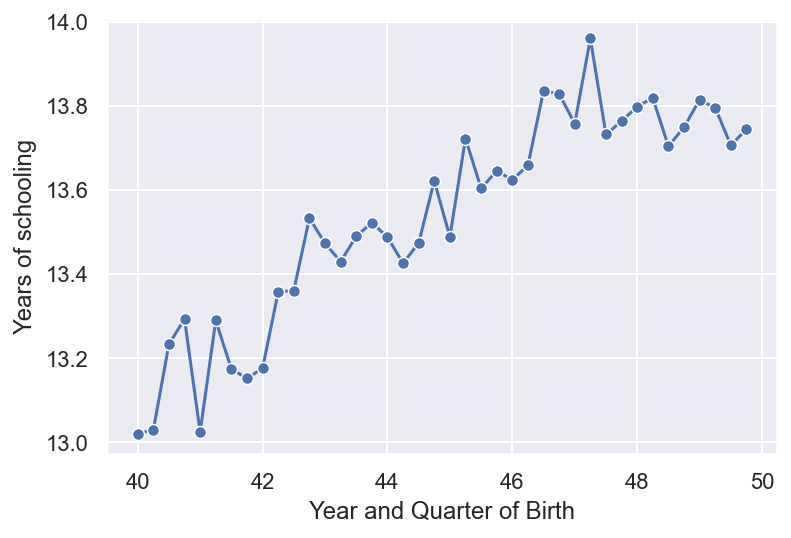

In [5]:
plot = sns.lineplot(data=df40, y='EDUC', x='yob_q', ci=None, marker='o')
plot.set(xlabel='Year and Quarter of Birth', ylabel='Years of schooling')
plt.show()

There is an increasing tend of the years of education. We need to take this effect, to not have biased results. Fixed effect for time.To have a better sense of the effect of being born in the last versus the first quarters of the year, we need to detrend the time series. 

In [6]:
df_avg = pd.DataFrame({'educ': df.groupby('yob_q')['EDUC'].mean()}).reset_index()
df_avg['ma_2'] = df_avg.educ.rolling(window=5, min_periods=5, center=True).sum().iloc[::1]
df_avg['ma_2'] = (df_avg['ma_2'] - df_avg['educ'])/4
df = df.merge(df_avg, how='left', on='yob_q')
df.head()

,AGE,AGEQ,EDUC,ENOCENT,ESOCENT,LWKLYWGE,MARRIED,MIDATL,MT,NEWENG,...,YR28,YR29,QTR1,QTR2,QTR3,QTR4,random,yob_q,educ,ma_2
0,46,46.25,18,0,0,5.908553,1,0,0,1,...,0.0,0.0,0.0,0.0,0.0,1.0,7.227906e-08,33.75,12.717438,12.655968
1,45,45.25,11,0,0,5.464953,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.183647e-06,1924.75,11.591770,11.523840
2,43,43.00,11,1,0,5.559889,1,0,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,2.024221e-06,1927.00,11.533557,11.574993
3,42,42.00,16,0,0,5.790019,1,0,0,0,...,1.0,0.0,1.0,0.0,0.0,0.0,2.418815e-06,38.00,12.949519,12.977089
4,48,48.00,11,0,0,5.829240,1,0,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,3.485916e-06,32.00,12.388527,12.682015


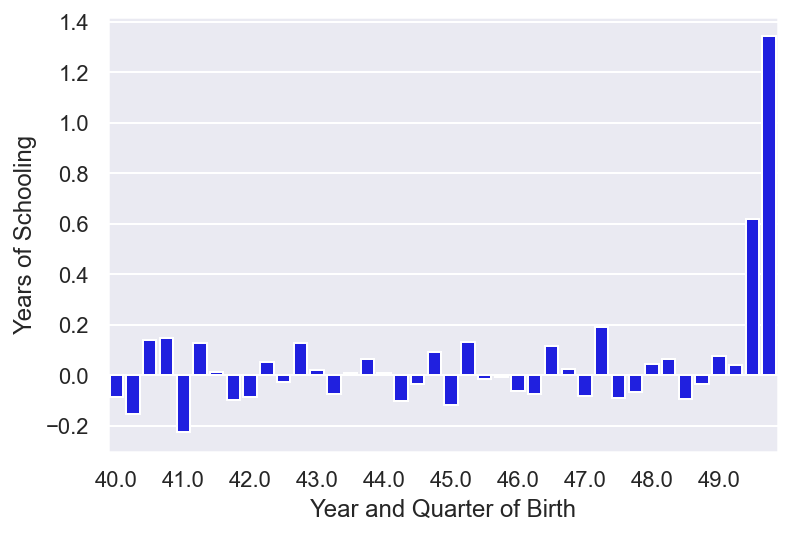

In [7]:
df['educ_std'] = df['educ'] - df['ma_2']
df40 = df.loc[df['COHORT']>39]
df40 = df40.loc[df['COHORT']<50]

plot = sns.barplot(x='yob_q', y='educ_std', data=df40, color='blue')
plot.set(xlabel='Year and Quarter of Birth', ylabel='Years of Schooling')
for ind, label in enumerate(plot.get_xticklabels()):
    if ind % 4 == 0: 
        label.set_visible(True)
    else:
        label.set_visible(False)
        
plt.show()

The fourth quarter has persistently more years of education than the next first quarter.

## OLS

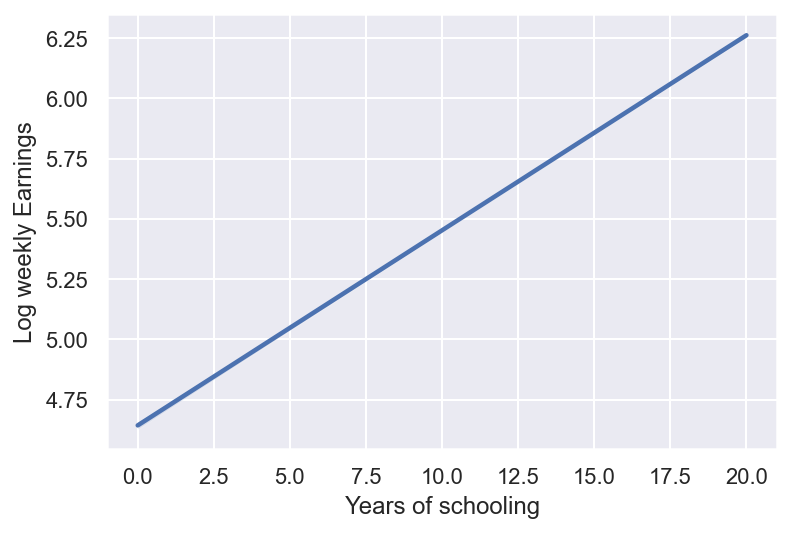

In [9]:
plot = sns.regplot(data=df, y='LWKLYWGE', x='EDUC', scatter=False, ci=95)
plot.set(ylabel='Log weekly Earnings', xlabel='Years of schooling')
plt.show()

In [10]:
from linearmodels.panel import PanelOLS
import statsmodels.api as sm

df['index'] = df.index
df = df.set_index(["index", "YOB"])

exog_vars = ['EDUC']
exog = sm.add_constant(df[exog_vars])
ols = PanelOLS(df.LWKLYWGE, exog, entity_effects=False).fit(cov_type='robust')
print(ols)

                          PanelOLS Estimation Summary                           
Dep. Variable:               LWKLYWGE   R-squared:                        0.1369
Estimator:                   PanelOLS   R-squared (Between):              0.1369
No. Observations:              200000   R-squared (Within):               0.0000
Date:                Fri, Nov 19 2021   R-squared (Overall):              0.1369
Time:                        09:14:48   Log-likelihood                -2.019e+05
Cov. Estimator:                Robust                                           
                                        F-statistic:                   3.172e+04
Entities:                      200000   P-value                           0.0000
Avg Obs:                       1.0000   Distribution:                F(1,199998)
Min Obs:                       1.0000                                           
Max Obs:                       1.0000   F-statistic (robust):          2.557e+04
                            

**What could be some OBSERVABLE confounders?** Prior and parent's wealth, 

In [10]:
from linearmodels.panel import compare

covs = ['NEWENG', 'MIDATL', 'ENOCENT', 'WNOCENT', 'SOATL', 'ESOCENT', 'WSOCENT', 'MT']
exog_vars = ['EDUC'] + covs
exog = sm.add_constant(df[exog_vars])
ols2 = PanelOLS(df.LWKLYWGE, exog, entity_effects=False).fit(cov_type='robust')
tfe = PanelOLS(df.LWKLYWGE, exog, entity_effects=False, time_effects=True).fit(cov_type='robust')

print(compare({"OLS": ols, "OLS Controls": ols2, "Time FE": tfe}, precision='std-errors'))

                        Model Comparison                       
                                  OLS OLS Controls      Time FE
---------------------------------------------------------------
Dep. Variable                LWKLYWGE     LWKLYWGE     LWKLYWGE
Estimator                    PanelOLS     PanelOLS     PanelOLS
No. Observations               200000       200000       200000
Cov. Est.                      Robust       Robust       Robust
R-squared                      0.1369       0.1427       0.1173
R-Squared (Within)             0.0000       0.0000       0.0000
R-Squared (Between)            0.1369       0.1427       0.1381
R-Squared (Overall)            0.1369       0.1427       0.1381
F-statistic                 3.172e+04       3697.8       2952.1
P-value (F-stat)               0.0000       0.0000       0.0000
=====================     ===========   ==========   ==========
const                          4.6432       4.6964       4.8951
                             (0.0068)   

**What could be some UNOBSERVED confounders? How can we account for these?** Most popular is skills. We can model them, or use IV.

## IV Estimation

There are two equivalent ways to calculate the IV coefficient. Both methods rely on the following assumptions to be valid: 

1. Relevance
2. Exogeneity of the instrument
3. Exclusion restriction

The only *testable* assumption is relevance and we will focus on it below.

### Step 1. First Stage

Both procedures require the estimation of the *first stage*, which is the coefficient form a regression of the explanatory variable (education) on the instrument (quarter of birth). The regression is the following: 

$$Educ_i = \gamma_0 + \gamma_1 qob_i + \mathbf{X'}_i \delta + u_i$$

where $\mathbf{X'}_i$ is a vector of covariates. The first stage coefficients is $\gamma_1$.

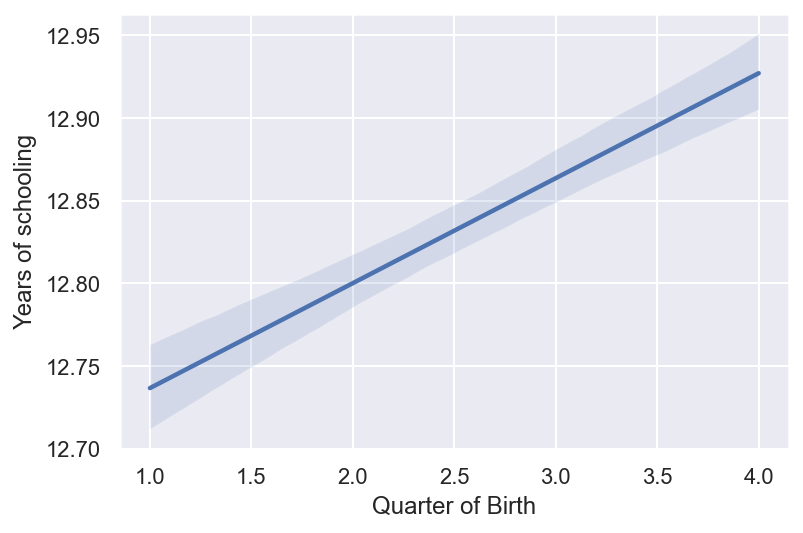

In [11]:
plot = sns.regplot(data=df, y='EDUC', x='QOB', scatter=False, ci=95)
plot.set(xlabel='Quarter of Birth', ylabel='Years of schooling')
plt.show()

In [12]:
exog_vars = ['QTR1', 'QTR2', 'QTR3']
exog = sm.add_constant(df[exog_vars])
fs = PanelOLS(df.EDUC, exog, entity_effects=False, time_effects=True).fit(cov_type='robust')
exog_vars = ['QTR1', 'QTR2', 'QTR3'] + covs
exog = sm.add_constant(df[exog_vars])
fs2 = PanelOLS(df.EDUC, exog, entity_effects=False, time_effects=True).fit(cov_type='robust')

print(compare({"FS": fs, "FS Controls": fs2}, precision='std-errors'))

                 Model Comparison                
                                  FS  FS Controls
-------------------------------------------------
Dep. Variable                   EDUC         EDUC
Estimator                   PanelOLS     PanelOLS
No. Observations              200000       200000
Cov. Est.                     Robust       Robust
R-squared                     0.0004       0.0221
R-Squared (Within)            0.0000       0.0000
R-Squared (Between)           0.0005       0.0196
R-Squared (Overall)           0.0005       0.0196
F-statistic                   23.505       411.50
P-value (F-stat)              0.0000       0.0000
=====================     ==========   ==========
const                         12.897       13.690
                            (0.0140)     (0.0217)
QTR1                         -0.1591      -0.1605
                            (0.0201)     (0.0199)
QTR2                         -0.0687      -0.0745
                            (0.0202)     (0.0200)


In [13]:
fs_coef = fs2.params[1]

The validity of the IV approach relies on three main assumptions, on of which concerns the first stage. One requirement for the estimate to be valid is that of **relevance** of the instrument, known also as having a **strong first stage**. This means that the instrument must be strongly predictive of the explanatory variable, namely, the first stage coefficient must be significant and not small. 

**Does this assumption hold in this context? Focus mostly on the coefficient on being born in the first quarter.**

### Step 2a. Reduced Form

The first approach requires the estimation of the coefficient from a regression of the outcome variable on the instrument and the same covariates used in the first stage. 

$$lwklywge_i = \alpha_0 + \alpha_1 qob_i + \mathbf{X'}_i \delta + \varepsilon_i$$

The reduced form coefficient is $\alpha_1$.

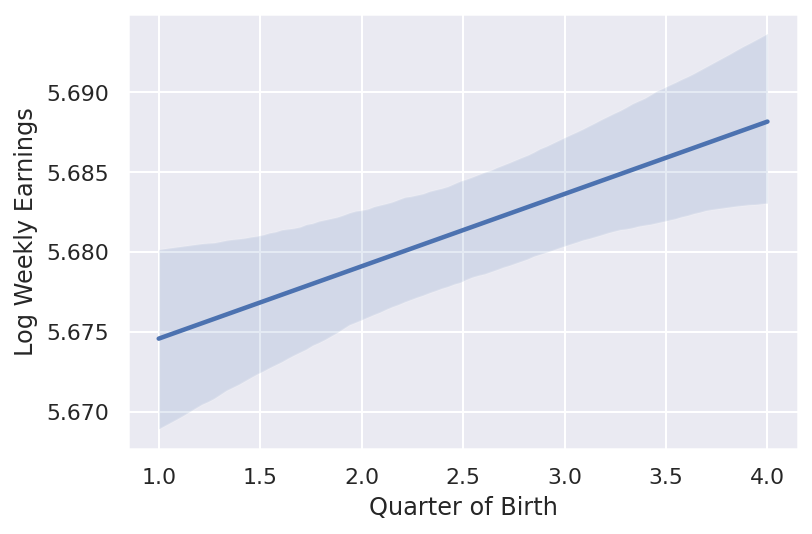

In [14]:
plot = sns.regplot(data=df, y='LWKLYWGE', x='QOB', scatter=False, ci=95)
plot.set(xlabel='Quarter of Birth', ylabel='Log Weekly Earnings')
plt.show()

In [15]:
exog_vars = ['QTR1', 'QTR2', 'QTR3']
exog = sm.add_constant(df[exog_vars])
rf = PanelOLS(df.LWKLYWGE, exog, entity_effects=False, time_effects=True).fit(cov_type='robust')
exog_vars = ['QTR1', 'QTR2', 'QTR3'] + covs
exog = sm.add_constant(df[exog_vars])
rf2 = PanelOLS(df.LWKLYWGE, exog, entity_effects=False, time_effects=True).fit(cov_type='robust')

rf_coef = rf2.params[1]
print(compare({"RF": rf, "RF Controls": rf2}, precision='std-errors'))

                 Model Comparison                 
                                   RF  RF Controls
--------------------------------------------------
Dep. Variable                LWKLYWGE     LWKLYWGE
Estimator                    PanelOLS     PanelOLS
No. Observations               200000       200000
Cov. Est.                      Robust       Robust
R-squared                   2.682e-05       0.0180
R-Squared (Within)             0.0000       0.0000
R-Squared (Between)         5.104e-05       0.0110
R-Squared (Overall)         5.104e-05       0.0110
F-statistic                    1.7879       334.13
P-value (F-stat)               0.1470       0.0000
=====================     ===========   ==========
const                          5.6821       5.7898
                             (0.0029)     (0.0047)
QTR1                          -0.0053      -0.0056
                             (0.0041)     (0.0041)
QTR2                          -0.0017      -0.0032
                             (0

**What can we say about the relationship between quarter of birth and earnings?**

### Step 3a. IV coefficient

Once we have the first stage and the reduced form coefficients, the IV coefficient is simply calculated by dividing the reduced form by the first stage: 

$$\beta_{IV} = \frac{\alpha_1}{\gamma_1}$$

**What do you expect on the sign of the relationship between education and wages?**

In [16]:
beta_iv = rf_coef/fs_coef
print(beta_iv)

0.035090437096080576


**Do you think that the exclusion restriction and the exogeneity assumptions are satisfied in this context?** It may affect your mental health, or parents wealth. Not testable. Thus the exogeneity assumption is not really satisfied.

## Two Stage Least Squares (2sls)

The second methodology to estimate the IV coefficient entails getting the predicted values from the first stage and running a regression of the outcome on these predicted values. The exclusion assumption is also problematic because of the mental health.

### Step 2b. Get FS predicted values


In [18]:
df['educ_hat1'] = fs.predict()
df['educ_hat2'] = fs2.predict()

df[['EDUC', 'educ_hat1', 'educ_hat2']].head()

,,EDUC,educ_hat1,educ_hat2
index,YOB,,,
0,33,18,12.897178,13.287455
1,1924,11,12.897178,12.968385
2,1927,11,12.738100,12.599027
3,38,16,12.738100,12.807868
4,32,11,12.738100,12.298748


### Step 3b. Regress the outcome on the predicted values

The regression is the following: 

$$lwklywge_i = \beta_0 + \beta_{2sls} \hat{EDUC}_i + \varepsilon_i$$

In [19]:
exog_vars = ['educ_hat1']
exog = sm.add_constant(df[exog_vars])
iv2sls = PanelOLS(df.LWKLYWGE, exog, entity_effects=False).fit(cov_type='robust')
exog_vars = ['educ_hat2']
exog = sm.add_constant(df[exog_vars])
iv2sls_2 = PanelOLS(df.LWKLYWGE, exog, entity_effects=False).fit(cov_type='robust')

print(compare({"2SLS": iv2sls, "2SLS Controls": iv2sls_2}, precision='std-errors'))

                Model Comparison               
                             2SLS 2SLS Controls
-----------------------------------------------
Dep. Variable            LWKLYWGE      LWKLYWGE
Estimator                PanelOLS      PanelOLS
No. Observations           200000        200000
Cov. Est.                  Robust        Robust
R-squared               5.135e-05        0.0074
R-Squared (Within)         0.0000        0.0000
R-Squared (Between)     5.135e-05        0.0074
R-Squared (Overall)     5.135e-05        0.0074
F-statistic                10.270        1495.4
P-value (F-stat)           0.0014        0.0000
===================== ===========    ==========
const                      4.5735        3.9994
                         (0.3464)      (0.0443)
educ_hat1                  0.0863              
                         (0.0270)              
educ_hat2                                0.1311
                                       (0.0034)
----------------------------------------

**Interpretation of the coefficient:**

## IV Estimation with linearmodels

In [22]:
from linearmodels.iv import IV2SLS

iv_set = df[['QTR1', 'QTR2', 'QTR3']]
exog = sm.add_constant(df[covs])
iv = IV2SLS(df.LWKLYWGE, exog, df.EDUC, iv_set).fit(cov_type='robust')

print(iv)

                          IV-2SLS Estimation Summary                          
Dep. Variable:               LWKLYWGE   R-squared:                      0.1421
Estimator:                    IV-2SLS   Adj. R-squared:                 0.1421
No. Observations:              200000   F-statistic:                    2625.4
Date:                Thu, Nov 18 2021   P-value (F-stat)                0.0000
Time:                        20:38:23   Distribution:                  chi2(9)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          4.7651     0.2785     17.108     0.0000      4.2192      5.3111
NEWENG        -0.0530     0.0108    -4.9210     0.00